In [1]:
import Ouzo_Graph_Tools as ouzo_graphs
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Loading json containers...
Json container file load complete, listing database
Found 0 containers to add. Starting migration...
Database migration complete!


In [2]:
# Step 1: Load the csv created from the command script.
sample_info = pd.read_csv(r"C:\Users\Edwin\Desktop\11_11_20\experiment_info")
pfh_wtfs = [float(i) for i in list(sample_info['Component 3 wtf'])[1:]]
etoh_wtfs = [float(i) for i in list(sample_info['Component 4 wtf'])[1:]]

In [3]:
# Step 2: Load the UV-Vis data,blank and combine it. 
plate1 =  pd.read_excel(r"C:\Users\Edwin\Desktop\11_11_20\11_11_2020_Plate1.xlsx", sheet_name = 'Sheet1' ).T
plate2 =  pd.read_excel(r"C:\Users\Edwin\Desktop\11_11_20\11_11_2020_Plate2.xlsx", sheet_name = 'Sheet1' ).T

In [4]:
# Step 3: Correct all data using baseline/blanking, make series first then subtract using .bbaselinecorrection
blank_series = plate2.iloc[-1]
plate1_blanked = ouzo_graphs.baseline_correction(plate1, blank_series)
plate2_blanked = ouzo_graphs.baseline_correction(plate2, blank_series)

In [ ]:
def wavelength_absorbances(uv_df):
    
    for i, (key, row) in enumerate(dataframe.iterrows()):
        if key == 'Wavelength':
            wavelengths = row
    
    index = np.where(wavelengths == wavelength)[0][0]
    wells = []
    absorbances = []
    for i, (key, row) in enumerate(dataframe.iterrows()):
        if key == 'Wavelength':
            pass
        else:
            well = key
            wells.append(well)
            absorbance = row[index]
            absorbances.append(absorbance)
    

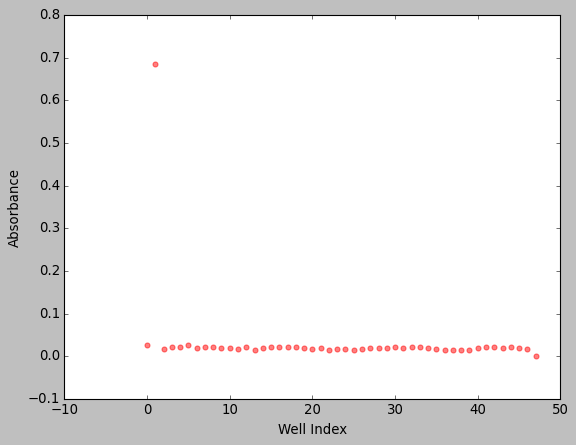

In [78]:
# Step 4: Extract the absorbances from the loaded UV-Vis data at a specified wavelength
wavelength = 550
plate1_absorbances = ouzo_graphs.plot_single_wavelength(plate1_blanked, wavelength)# rearrnge x axis based on concentration or something
plate1_absorbances[1] = 0

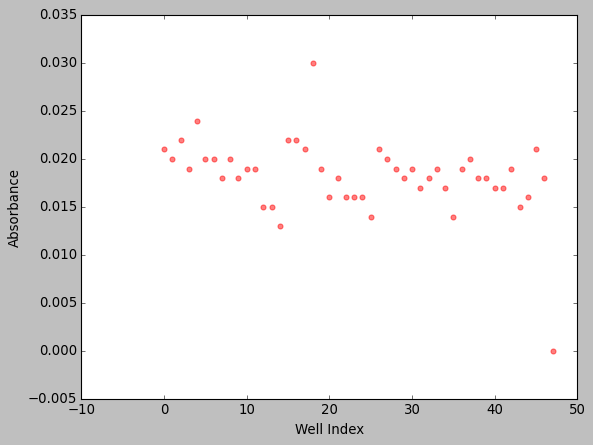

In [79]:
plate2_absorbances = ouzo_graphs.plot_single_wavelength(plate2_blanked, wavelength)
combined_absorbances = plate1_absorbances + plate2_absorbances

(0.0005, 0.0021)

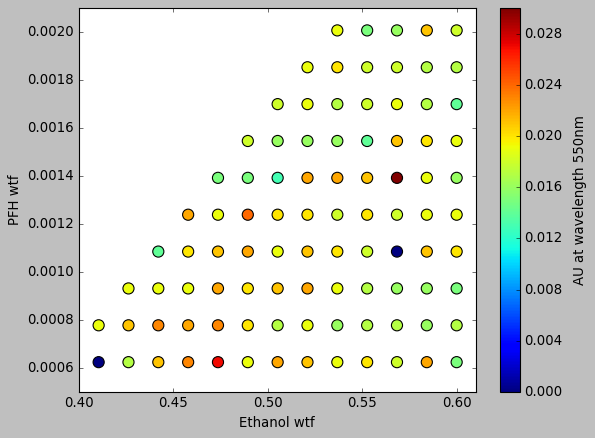

In [80]:
plt.style.use('classic')
plt.scatter(etoh_wtfs, pfh_wtfs, s=100, c = combined_absorbances)
plt.xlabel("Ethanol wtf")
plt.ylabel("PFH wtf")
color_bar = plt.colorbar()
color_bar_txt = "AU at wavelength " + str(wavelength) + 'nm'
color_bar.set_label(color_bar_txt, labelpad = 10)
plt.xlim([0.4,0.61])
plt.ylim([0.0005, 0.0021])
# plt.clim(0, 0.030)

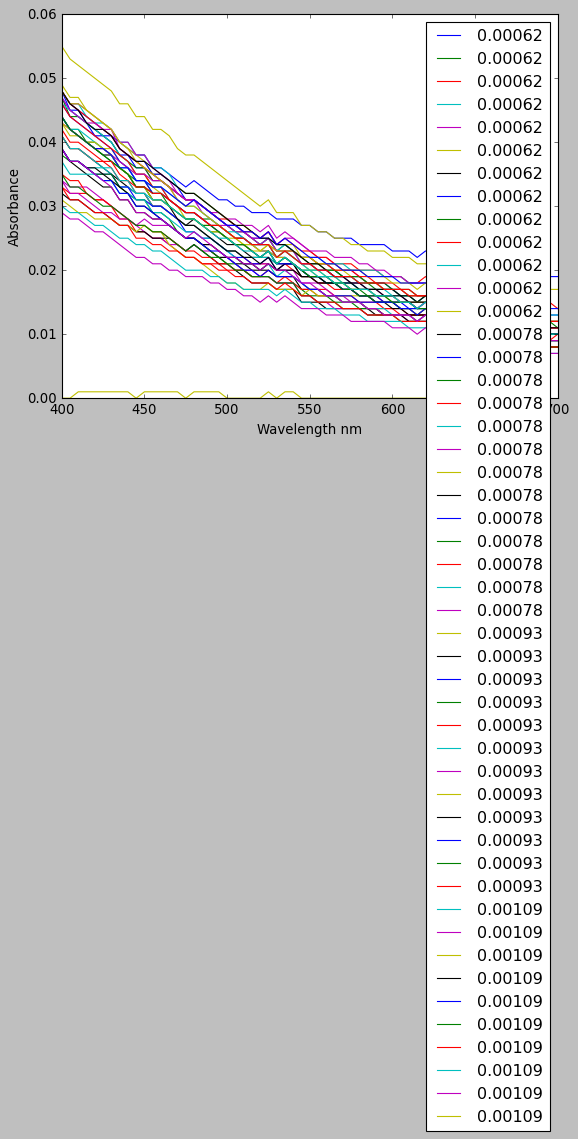

In [24]:
df = plate1_blanked
# color_bar = plt.colorbar()
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded[0:96], y_lim=[0,0.06]) # so still under resolution
# can you do a color bar like image on this 

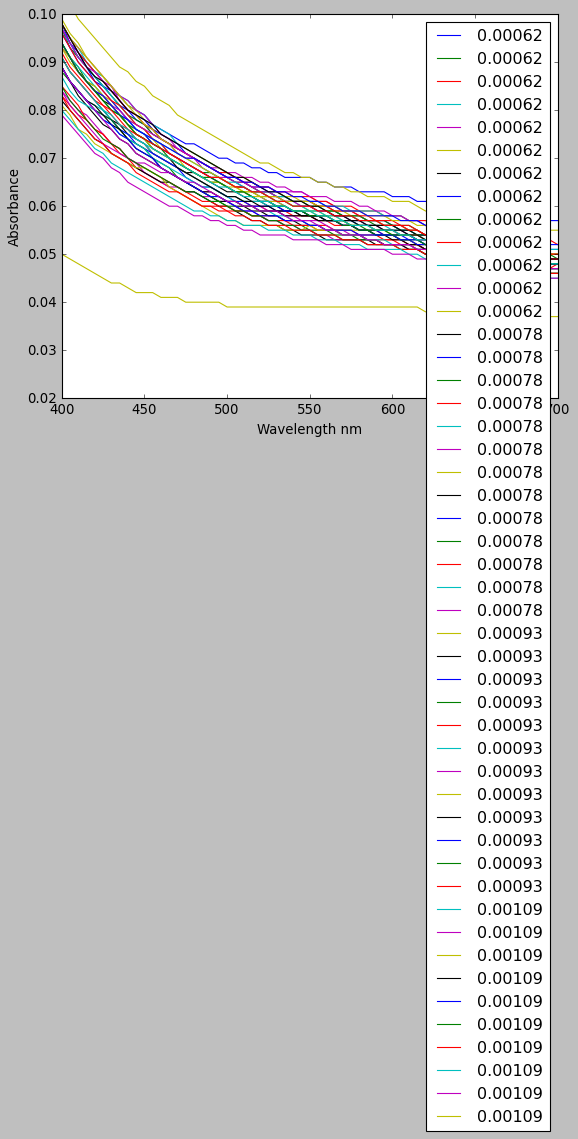

In [37]:
df = plate1
# color_bar = plt.colorbar()
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded[0:96], y_lim=[0.02,0.1]) # so still under resolution
# can you do a color bar like image on this 

In [32]:
plate1_blanked

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Wavelength,400.000,405.000,410.000,415.000,420.000,425.000,430.000,435.000,440.000,445.000,...,655.000,660.000,665.000,670.000,675.000,680.000,685.000,690.000,695.000,700.000
A1,0.048,0.046,0.045,0.044,0.043,0.042,0.041,0.040,0.039,0.038,...,0.021,0.021,0.020,0.020,0.020,0.020,0.019,0.019,0.019,0.019
A2,0.741,0.733,0.727,0.725,0.722,0.725,0.726,0.719,0.715,0.712,...,0.669,0.668,0.670,0.668,0.667,0.667,0.669,0.667,0.666,0.669
A3,0.033,0.032,0.032,0.032,0.031,0.031,0.030,0.028,0.028,0.026,...,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009,0.010
A4,0.048,0.046,0.046,0.044,0.043,0.043,0.042,0.040,0.040,0.038,...,0.013,0.013,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011
A5,0.048,0.046,0.046,0.045,0.044,0.043,0.042,0.039,0.038,0.037,...,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011,0.011,0.011
A6,0.055,0.053,0.052,0.051,0.050,0.049,0.048,0.046,0.046,0.044,...,0.019,0.019,0.019,0.018,0.018,0.018,0.018,0.018,0.017,0.017
A7,0.041,0.039,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,...,0.011,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009
A8,0.048,0.045,0.045,0.043,0.042,0.041,0.041,0.039,0.038,0.036,...,0.014,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.012
B1,0.044,0.042,0.041,0.040,0.040,0.039,0.038,0.036,0.035,0.034,...,0.013,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.011
